In [ ]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from pandas.plotting import scatter_matrix

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

# https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset

class SpotifyUnsupervisedPipeline:
    def __init__(self, data_path, eda_output_dir='./eda', sample_fraction=0.25):
        self.data_path = data_path
        self.eda_output_dir = eda_output_dir
        os.makedirs(self.eda_output_dir, exist_ok=True)
        sns.set(style='whitegrid', context='notebook')
        
        self.df = None
        self.df_scaled = None
        
        self.numeric_features = ['acousticness', 'danceability', 'energy', 
                                 'instrumentalness', 'liveness', 'loudness', 
                                 'speechiness', 'valence', 'tempo', "popularity"]
        self.sample_fraction = sample_fraction

    def print_process(self, text = "",):
        output_text = f'Starting: {text}'
        output = "==== " + output_text
        print(output)
        

    def load_data(self):
        self.print_process("load_data")
        self.df = pd.read_csv(self.data_path)
        print("Data loaded with shape:", self.df.shape)

    def data_understanding(self):
        print("\nDataFrame Info:")
        print("Available features in dataset before dropping:", list(self.df.columns))
        print(self.df.info())
        print("\nDescriptive Statistics:\n", self.df.describe())

    def preprocess(self):
        self.print_process("preprocess")
        # DROP ROWS WITH MISSING VALUES
        initial_rows = self.df.shape[0]
        self.df.dropna(inplace=True)
        final_rows = self.df.shape[0]
        dropped_count = initial_rows - final_rows
        print("Dropped rows count:", dropped_count)


        # ENSURE SCALING
        scaler = StandardScaler()
        scaled_values = scaler.fit_transform(self.df[self.numeric_features])
        self.df_scaled = pd.DataFrame(scaled_values, columns=self.numeric_features)
        print("Data scaling completed.")

    def perform_eda(self, show_plots=True, save_plots=True):
        self.print_process("perform_eda")

        # Histograms for each numerical feature
        for feature in self.numeric_features:
            plt.figure(figsize=(8, 4))
            sns.histplot(self.df[feature], kde=True, bins=30)
            plt.title(f'Distribution of {feature}')
            plt.xlabel(feature)
            plt.ylabel('Frequency')
            if save_plots:
                plt.savefig(os.path.join(self.eda_output_dir, f'dist_hist_{feature}.png'))
            if show_plots:
                plt.show()
            plt.close()
        
        # Correlation Heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(self.df[self.numeric_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Heatmap of Audio Features')
        if save_plots:
            plt.savefig(os.path.join(self.eda_output_dir, 'correlation_heatmap.png'))
        if show_plots:
            plt.show()
        plt.close()

        vif_data = pd.DataFrame()
        vif_data['Feature'] = self.numeric_features
        vif_data['VIF'] = [variance_inflation_factor(self.df[self.numeric_features].values, i)
                           for i in range(len(self.numeric_features))]
        print("Variance Inflation Factors:")
        print(vif_data)
        
        # Missing Data Visualization
        plt.figure(figsize=(10, 4))
        msno.matrix(self.df, figsize=(10, 4), color=(0.2, 0.4, 0.6))
        plt.title('Missing Data Visualization')
        if save_plots:
            plt.savefig(os.path.join(self.eda_output_dir, 'missing_data.png'))
        if show_plots:
            plt.show()
        plt.close()
        
        # Pair Plot for Numerical Features
        pair_plot = sns.pairplot(self.df[self.numeric_features])
        pair_plot.fig.suptitle('Pair Plot of Audio Features', y=1.02)
        if save_plots:
            pair_plot.savefig(os.path.join(self.eda_output_dir, 'pair_plot.png'))
        if show_plots:
            plt.show()
        plt.close('all')
        
        # Box Plots for Outlier Detection
        for feature in self.numeric_features:
            plt.figure(figsize=(8, 4))
            sns.boxplot(x=self.df[feature], color='skyblue')
            plt.title(f'Box Plot of {feature}')
            plt.xlabel(feature)
            if save_plots:
                plt.savefig(os.path.join(self.eda_output_dir, f'boxplot_{feature}.png'))
            if show_plots:
                plt.show()
            plt.close()
        
        # Scatter Matrix for Additional Correlation Analysis
        plt.figure(figsize=(12, 12))
        scatter_matrix(self.df[self.numeric_features], figsize=(12, 12), diagonal='kde', alpha=0.7)
        plt.suptitle('Scatter Matrix of Audio Features')
        if save_plots:
            plt.savefig(os.path.join(self.eda_output_dir, 'scatter_matrix.png'))
        if show_plots:
            plt.show()
        plt.close()
        
        # Skewness and Kurtosis
        skewness = self.df[self.numeric_features].skew()
        kurtosis = self.df[self.numeric_features].kurtosis()
        print("Skewness of numerical features:\n", skewness)
        print("\nKurtosis of numerical features:\n", kurtosis)

    def determine_pca_n_components(self):
        # Fit PCA on the scaled data with all components
        pca_full = PCA(n_components=None)
        pca_full.fit(self.df_scaled)

        explained_variance = pca_full.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)

        # Plot individual explained variance as bars
        plt.figure(figsize=(10, 6))
        plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, label='Individual Explained Variance')

        # Plot cumulative explained variance as a smooth line
        plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='red', label='Cumulative Explained Variance')

        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.title('Scree Plot with Cumulative Explained Variance')
        plt.legend(loc='best')
        plt.savefig(os.path.join(self.eda_output_dir, 'scree_var_exp_cumsum_exp.png'))
        plt.show()

        # Determine the number of components for a desired threshold (e.g., 90%)
        threshold = 0.90
        n_components_needed = np.argmax(cumulative_variance >= threshold) + 1
        print(f"Number of components needed to explain at least {threshold*100}% variance: {n_components_needed}")
        return n_components_needed

    def apply_pca(self, n_components=2):

        self.print_process("apply_pca")
        print("Using ", n_components, " n_components for pairwise")
        
        # Perform PCA on TWO components.. even if passed 7, you can see it calls 2 below 
        pca = PCA(n_components=n_components)
        pca_components = pca.fit_transform(self.df_scaled)
        self.df['PCA1'] = pca_components[:, 0]
        self.df['PCA2'] = pca_components[:, 1]
        self.pca = pca
        print("PCA applied and components added to dataframe.")

        loadings = pd.DataFrame(
            self.pca.components_, 
            columns=self.numeric_features, 
            index=[f'PC{i+1}' for i in range(self.pca.n_components_)]
        )
        print("\nPCA Loadings (which features most influence each PC):")
        print(loadings)

        # Create scatter plot of the two PCA components
        plt.figure(figsize=(8, 6))
        plt.scatter(self.df['PCA1'], self.df['PCA2'], alpha=0.7)
        plt.xlabel('PCA1')
        plt.ylabel('PCA2')
        plt.title('PCA Projection')
        
        unique_filename = f"silhouette_method_subsampled_pca.png"
        file_path = os.path.join(self.eda_output_dir, unique_filename)
        
        # Save the plot
        plt.savefig(file_path)
        plt.show()
        plt.close()
        print(f"Plot saved as {file_path}")


        # PAIRWISE PCA
        df_pca = pd.DataFrame(
            data=pca_components,
            columns=[f'PC{i+1}' for i in range(n_components)] 
        )

        sns.pairplot(df_pca, diag_kind='kde')
        plt.suptitle("Pairplot of the first 4 Principal Components", y=1.02)

        plt.savefig(os.path.join(self.eda_output_dir, 'pair_pca.png'))
        plt.show()

    def determine_kmeans_n_cluster(self, use_sample_for_silhouette):
        self.print_process("determine_kmeans_n_cluster")
        #####  SILHOUETTE SCORE ######
        if True:
            sample_size = int(self.sample_fraction * self.df_scaled.shape[0])
            sample_indices = np.random.choice(self.df_scaled.shape[0], sample_size, replace=False)
            if isinstance(self.df_scaled, np.ndarray):
                df_sample = self.df_scaled[sample_indices]
            else:
                df_sample = self.df_scaled.iloc[sample_indices]
            silhouette_scores = []
            k_values = range(2, 15)
            for k_val in k_values:
                print(f"Testing k={k_val}")
                kmeans_temp = MiniBatchKMeans(n_clusters=k_val, random_state=1337, batch_size=256)
                labels = kmeans_temp.fit_predict(df_sample)
                silhouette_avg = silhouette_score(df_sample, labels)
                silhouette_scores.append(silhouette_avg)
            plt.figure(figsize=(8, 6))
            plt.plot(k_values, silhouette_scores, marker='o')
            plt.title('Silhouette Score For Optimal k (Subsampled Data)')
            plt.xlabel('Number of clusters (k)')
            plt.ylabel('Silhouette Score')
            plt.xticks(k_values)
            plt.savefig(os.path.join(self.eda_output_dir, 'k-mean-silhouette_method_subsampled.png'))
            plt.show()
            plt.close()


            #####  ELBOW METHOD ######

            sample_size = int(self.sample_fraction * self.df_scaled.shape[0])
            sample_indices = np.random.choice(self.df_scaled.shape[0], sample_size, replace=False)
            df_for_elbow = self.df_scaled.iloc[sample_indices] if not isinstance(self.df_scaled, np.ndarray) else self.df_scaled[sample_indices]

            
            inertias = []
            
            # Loop over the possible k-values, fit KMeans, and record the inertia
            for k in k_values:
                print(f"Computing inertia for k={k} ...")
                kmeans = KMeans(n_clusters=k, random_state=42)
                kmeans.fit(df_for_elbow)
                inertias.append(kmeans.inertia_)
            
            # Plot the elbow curve
            plt.figure(figsize=(8, 6))
            plt.plot(k_values, inertias, marker='o', linestyle='-')
            plt.title('Elbow Method: Inertia vs. Number of Clusters')
            plt.xlabel('Number of Clusters (k)')
            plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
            plt.xticks(k_values)
            plt.grid(True)
            
            
            plt.savefig(os.path.join(self.eda_output_dir, 'k-mean-elbow_method_inertia.png'))

            plt.show()
            plt.close()
            
            print(inertias)

            #####  Calinski-Harabasz /  Davies-Bouldin  ######

            self.print_process("determine_k_using_indices")
    
            # Optionally use a subsample to speed up computations

            sample_size = int(self.sample_fraction * self.df_scaled.shape[0])
            sample_indices = np.random.choice(self.df_scaled.shape[0], sample_size, replace=False)
            df_for_indices = self.df_scaled.iloc[sample_indices] if not isinstance(self.df_scaled, np.ndarray) else self.df_scaled[sample_indices]

            
            ch_scores = []
            db_scores = []
            
            for k in k_values:
                print(f"Computing indices for k={k} ...")
                kmeans = KMeans(n_clusters=k, random_state=42)
                kmeans.fit(df_for_indices)
                labels = kmeans.labels_
                ch = calinski_harabasz_score(df_for_indices, labels)
                db = davies_bouldin_score(df_for_indices, labels)
                ch_scores.append(ch)
                db_scores.append(db)
            
            plt.figure(figsize=(14, 6))
            
            # Plot Calinski-Harabasz scores
            plt.subplot(1, 2, 1)
            plt.plot(list(k_values), ch_scores, marker='o')
            plt.title('Calinski-Harabasz Index vs. Number of Clusters')
            plt.xlabel('Number of Clusters (k)')
            plt.ylabel('Calinski-Harabasz Score')
            plt.xticks(list(k_values))
            plt.grid(True)
            
            # Plot Davies-Bouldin scores
            plt.subplot(1, 2, 2)
            plt.plot(list(k_values), db_scores, marker='o', color='red')
            plt.title('Davies-Bouldin Index vs. Number of Clusters')
            plt.xlabel('Number of Clusters (k)')
            plt.ylabel('Davies-Bouldin Score')
            plt.xticks(list(k_values))
            plt.grid(True)
            
            plt.savefig(os.path.join(self.eda_output_dir, 'clustering_indices.png'))
            plt.show()
            plt.close()
            print("ch_scores", ch_scores)
            print("db_scores", db_scores)


    def show_kmeans_centroids(self, kmeans_model):
        # Get centroids in scaled space
        centroids = kmeans_model.cluster_centers_
        centroids_df = pd.DataFrame(centroids, columns=self.numeric_features)
        
        print("\nK-Means Cluster Centroids (in scaled space):")
        print(centroids_df)
        
        # Optionally, visualize the centroids using a heatmap
        plt.figure(figsize=(10, 6))
        sns.heatmap(centroids_df, annot=True, cmap='coolwarm')
        plt.title("K-Means Cluster Centroids")
        plt.xlabel("Features")
        plt.ylabel("Cluster")

        plt.savefig(os.path.join(self.eda_output_dir, 'k-mean-heatmap-clusteroid.png'))
        plt.show()

    def run_kmeans(self, n_clusters=3):
            self.print_process("run_kmeans")
    
            # Run final K-Means clustering on the full scaled dataset
            kmeans = KMeans(n_clusters=n_clusters, random_state=1337)
            self.df['Cluster'] = kmeans.fit_predict(self.df_scaled)
            print(f"K-Means clustering completed with {n_clusters} clusters.")
            
            self.show_kmeans_centroids(kmeans)

            # If PCA has been applied, transform the cluster centers into PCA space
            if hasattr(self, 'pca'):
                centers_scaled = kmeans.cluster_centers_
                centers_pca = self.pca.transform(centers_scaled)
            
            # Plot the clusters in PCA space
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=self.df, palette='Set1', s=50)
            
            # Overlay cluster centers
            if hasattr(self, 'pca'):
                plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
                            c='black', s=200, alpha=0.6, marker='X',
                            label='Centroids')
                plt.legend()
            
            plt.title('K-Means Clusters with Centroids')
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            
            save_path = os.path.join(self.eda_output_dir, 'kmeans_clusters_with_centroids.png')
            plt.savefig(save_path)
            plt.show()
            plt.close()




        
    def run_dbscan(self, fixed_eps=1.0, min_samples_list=range(3, 20, 2), neighbors=10, adjusted_params=(1.2, 12)):
        # Compute k-distance graph
        nn = NearestNeighbors(n_neighbors=neighbors)
        nn.fit(self.df_scaled)
        distances, _ = nn.kneighbors(self.df_scaled)
        k_distances = np.sort(distances[:, neighbors - 1])
        plt.figure(figsize=(8, 6))
        plt.plot(k_distances)
        plt.xlabel('Points sorted by distance')
        plt.ylabel(f'Distance to {neighbors}th nearest neighbor')
        plt.title('K-Distance Graph for DBSCAN eps Determination')

        plt.savefig(os.path.join(self.eda_output_dir, 'db_k-distance-eps-determination.png'))
        plt.show()
        plt.close()
        
        # Test different min_samples with fixed eps
        n_clusters = []
        n_noise = []
        for min_samples in min_samples_list:
            dbscan_temp = DBSCAN(eps=fixed_eps, min_samples=min_samples)
            labels = dbscan_temp.fit_predict(self.df_scaled)
            n_cluster = len(set(labels)) - (1 if -1 in labels else 0)
            n_clusters.append(n_cluster)
            n_noise.append(np.sum(labels == -1))
        plt.figure(figsize=(8, 6))
        plt.plot(list(min_samples_list), n_clusters, marker='o', label='Number of Clusters')
        plt.plot(list(min_samples_list), n_noise, marker='s', label='Number of Noise Points')
        plt.xlabel('min_samples')
        plt.ylabel('Count')
        plt.title('DBSCAN: Clusters and Noise vs. min_samples')
        plt.legend()

        plt.savefig(os.path.join(self.eda_output_dir, 'db_clusters-noise-vs-min-samp'))
        plt.show()
        plt.close()

        #### SCALED
        # Run DBSCAN with adjusted parameters (eps, min_samples)
        eps_adj, min_samples_adj = adjusted_params
        dbscan = DBSCAN(eps=eps_adj, min_samples=min_samples_adj)
        self.df['DBSCAN_Cluster'] = dbscan.fit_predict(self.df_scaled)
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='Set2', data=self.df, s=50)
        plt.title('DBSCAN Clustering on PCA-reduced Data')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend(title='DBSCAN Cluster')
        plt.savefig(os.path.join(self.eda_output_dir, 'db_dbscan_clusters_adjusted.png'))
        plt.show()
        plt.close()
        n_clusters_found = len(set(self.df['DBSCAN_Cluster'])) - (1 if -1 in self.df['DBSCAN_Cluster'] else 0)
        print(f"DBSCAN found {n_clusters_found} clusters (excluding noise).")


    def determine_linkage_hp(self, n_clusters=4, sample_fraction_hp=0.1, linkage_options=['ward', 'complete', 'average', 'single']):
        # Subsample data for evaluation.
        
        np.random.seed(1337)
        sample_size = int(sample_fraction_hp * self.df_scaled.shape[0])
        sample_indices = np.random.choice(self.df_scaled.shape[0], sample_size, replace=False)
        # Ensure we work with numpy array values.
        if not isinstance(self.df_scaled, np.ndarray):
            data_sample = self.df_scaled.iloc[sample_indices].values
        else:
            data_sample = self.df_scaled[sample_indices]
        
        # Evaluate each linkage method.
        silhouette_scores = {}
        for link in linkage_options:
            agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage=link)
            labels = agg_cluster.fit_predict(data_sample)
            score = silhouette_score(data_sample, labels)
            silhouette_scores[link] = score
            print(f"Linkage: {link} - Silhouette Score: {score:.3f}")
        
        # Plot the results.
        plt.figure(figsize=(8, 6))
        plt.bar(list(silhouette_scores.keys()), list(silhouette_scores.values()))
        plt.xlabel('Linkage Method')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Score for Different Linkage Methods')
        linkage_filename = os.path.join(self.eda_output_dir, 'agglo_hp_linkage.png')
        plt.savefig(linkage_filename)
        plt.show()
        plt.close()
        print(f"Linkage analysis saved as {linkage_filename}.")

    def determine_agglomerative_hp(self, sample_fraction_hp=0.1, linkage_method='ward', silhouette_range=range(2, 15)):

        np.random.seed(1337)
        # Subsample data for hyperparameter evaluation.
        sample_size = int(sample_fraction_hp * self.df_scaled.shape[0])
        sample_indices = np.random.choice(self.df_scaled.shape[0], sample_size, replace=False)
        if isinstance(self.df_scaled, np.ndarray):
            data_sample = self.df_scaled[sample_indices]
        else:
            data_sample = self.df_scaled.iloc[sample_indices].values


        
        # Create and save a dendrogram.
        Z = linkage(data_sample, method=linkage_method)
        plt.figure(figsize=(12, 8))
        dendrogram(Z, truncate_mode='level', p=5)
        plt.title('Agglomerative Clustering Dendrogram')
        plt.xlabel('Sample Index or Cluster Size')
        plt.ylabel('Distance')
        dendrogram_filename = os.path.join(self.eda_output_dir, 'agglo_hp_dendrogram.png')
        plt.savefig(dendrogram_filename)
        plt.show()
        plt.close()
        print(f"Dendrogram saved as {dendrogram_filename}.")
        
        # Compute and plot silhouette scores for a range of cluster numbers.
        silhouette_scores = []
        for k in silhouette_range:
            agg_cluster = AgglomerativeClustering(n_clusters=k, linkage=linkage_method)
            labels = agg_cluster.fit_predict(data_sample)
            score = silhouette_score(data_sample, labels)
            silhouette_scores.append(score)
        
        plt.figure(figsize=(8, 6))
        plt.plot(list(silhouette_range), silhouette_scores, marker='o')
        plt.title('Silhouette Score vs. Number of Clusters (Agglomerative)')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score')
        plt.xticks(list(silhouette_range))
        silhouette_filename = os.path.join(self.eda_output_dir, 'agglo_hp_silhouette.png')
        plt.savefig(silhouette_filename)
        plt.show()
        plt.close()
        print(f"Silhouette score plot saved as {silhouette_filename}.")

    def run_agglomerative(self, n_clusters=6, linkage="average"):
        np.random.seed(1337)

        sample_size = int(self.sample_fraction * self.df_scaled.shape[0])
        sample_indices = np.random.choice(self.df_scaled.shape[0], sample_size, replace=False)

        if not isinstance(self.df_scaled, np.ndarray):
            df_sample = self.df_scaled.iloc[sample_indices]
        else:
            df_sample = self.df_scaled[sample_indices]
        
        agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        sample_clusters = agg_cluster.fit_predict(df_sample)



        # pca_sample = self.df.loc[sample_indices, ['PCA1', 'PCA2']] # after an hour of debugging, don't use
        pca_sample = self.df.iloc[sample_indices][['PCA1', 'PCA2']]

        plt.figure(figsize=(8, 6))
        sns.scatterplot(x='PCA1', y='PCA2', hue=sample_clusters, palette='Set1', data=pca_sample, s=50)
        plt.title('Agglomerative Clustering on Downsampled PCA-reduced Data - Linkage: ' + linkage)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend(title='Agglomerative Cluster')
        
        plt.savefig(os.path.join(self.eda_output_dir, f'aggro_{linkage}_{n_clusters}_plot_.png'))

        plt.show()
        plt.close()
        return sample_indices, sample_clusters

    def run_tsne(self, sample_indices, sample_clusters, perplexity=30):
        if isinstance(self.df_scaled, np.ndarray):
            df_sample = self.df_scaled[sample_indices]
        else:
            df_sample = self.df_scaled.iloc[sample_indices]
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
        tsne_components = tsne.fit_transform(df_sample)
        
        df_tsne = self.df.iloc[sample_indices][['PCA1', 'PCA2']].copy()

        df_tsne['TSNE1'] = tsne_components[:, 0]
        df_tsne['TSNE2'] = tsne_components[:, 1]
        df_tsne['Cluster'] = sample_clusters
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', palette='Set1', data=df_tsne, s=50)
        plt.title('t-SNE Clustering Visualization')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.legend(title='Cluster')
        plt.savefig(os.path.join(self.eda_output_dir, 'tsne_clusters.png'))
        plt.show()
        plt.close()

    def cluster_profiling(self, sample_indices, sample_clusters):
        df_sample_orig = self.df.loc[sample_indices, self.numeric_features].copy()
        df_sample_orig['Cluster'] = sample_clusters
        cluster_summary = df_sample_orig.groupby('Cluster').mean()
        print("Cluster Summary (Means):")
        print(cluster_summary)
        
        # Create grouped box plots for each numeric feature
        n_features = len(self.numeric_features)
        n_cols = 3
        n_rows = math.ceil(n_features / n_cols)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
        axes = axes.flatten()
        for i, feature in enumerate(self.numeric_features):
            sns.boxplot(x='Cluster', y=feature, data=df_sample_orig, palette='Set1', ax=axes[i])
            axes[i].set_title(f'{feature} by Cluster')
            axes[i].set_xlabel('Cluster')
            axes[i].set_ylabel(feature)
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])
        plt.tight_layout()
        plt.savefig(os.path.join(self.eda_output_dir, 'cluster_prof_boxplots_grid.png'))
        plt.show()
        plt.close()

    def plot_clusters(self, cluster_col='Cluster', show_plots=True, save_plot=True):
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x='PCA1', y='PCA2', hue=cluster_col, data=self.df, palette='Set1', s=50)
        plt.title(f'Clusters Visualization ({cluster_col})')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend(title=cluster_col)
        if save_plot:
            plt.savefig(os.path.join(self.eda_output_dir, f'{cluster_col}_clusters.png'))
        if show_plots:
            plt.show()
        plt.close()


def main(show_eda = True):
    pipeline = SpotifyUnsupervisedPipeline(data_path='dataset.csv', eda_output_dir='./eda', sample_fraction=0.25)
    
    # LOAD AND DATA UNDERSTANDING
    pipeline.load_data()
    pipeline.data_understanding()
    
    # PREPROCESSING
    pipeline.preprocess()
    
    #  EDA
    pipeline.perform_eda(show_plots=show_eda, save_plots=True)
    
    # PCA 
    n_components_needed = pipeline.determine_pca_n_components()

    # Apply PCA for visualization
    pipeline.apply_pca(n_components=n_components_needed)
    
    # K-MEANS
    pipeline.determine_kmeans_n_cluster(use_sample_for_silhouette=True)
    pipeline.run_kmeans(n_clusters=8)
    pipeline.plot_clusters(cluster_col='Cluster', show_plots=True, save_plot=True)
    
    # DBSCAN
    pipeline.run_dbscan(fixed_eps=1.0, min_samples_list=range(3, 20, 2), neighbors=10, adjusted_params=(1.5, 20))
    
    n_clusters = 5
    # AGGLOMERATIVE
    pipeline.determine_linkage_hp()
    pipeline.determine_agglomerative_hp()
    sample_indices, sample_clusters = pipeline.run_agglomerative(n_clusters=n_clusters, linkage="ward")

    # USED FOR COMPARISONS
    # pipeline.run_agglomerative(n_clusters=n_clusters, linkage="ward")
    # pipeline.run_agglomerative(n_clusters=n_clusters, linkage="average")
    # pipeline.run_agglomerative(n_clusters=n_clusters, linkage="single")
    
    
    # T-SNE
    pipeline.run_tsne(sample_indices, sample_clusters, perplexity=30)
    
    # CLUSTER PROFILING
    pipeline.cluster_profiling(sample_indices, sample_clusters)



==== Starting: load_data
Data loaded with shape: (114000, 21)

DataFrame Info:
Available features in dataset before dropping: ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   da

<Figure size 1200x1200 with 0 Axes>

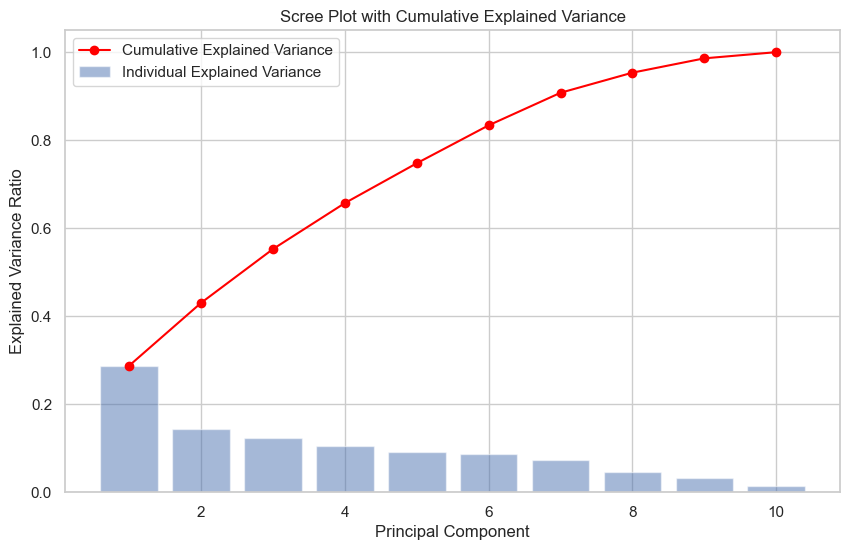

Number of components needed to explain at least 90.0% variance: 7
==== Starting: apply_pca
Using  7  n_components for pairwise
PCA applied and components added to dataframe.

PCA Loadings (which features most influence each PC):
     acousticness  danceability    energy  instrumentalness  liveness  \
PC1     -0.439087      0.246263  0.508481         -0.283461  0.084820   
PC2      0.296054      0.574051 -0.278203         -0.308421 -0.234984   
PC3      0.221716     -0.075239 -0.002589         -0.175288  0.666470   
PC4      0.098183     -0.151358 -0.082545         -0.364602  0.153578   
PC5      0.290785     -0.175417 -0.166562         -0.271767 -0.007401   
PC6     -0.069337      0.313690  0.001721          0.406501 -0.294884   
PC7     -0.015711      0.219446  0.054195          0.522534  0.545837   

     loudness  speechiness   valence     tempo  popularity  
PC1  0.517007     0.099741  0.294144  0.188948    0.031523  
PC2 -0.078214     0.022223  0.518949 -0.279581    0.031535  
PC3

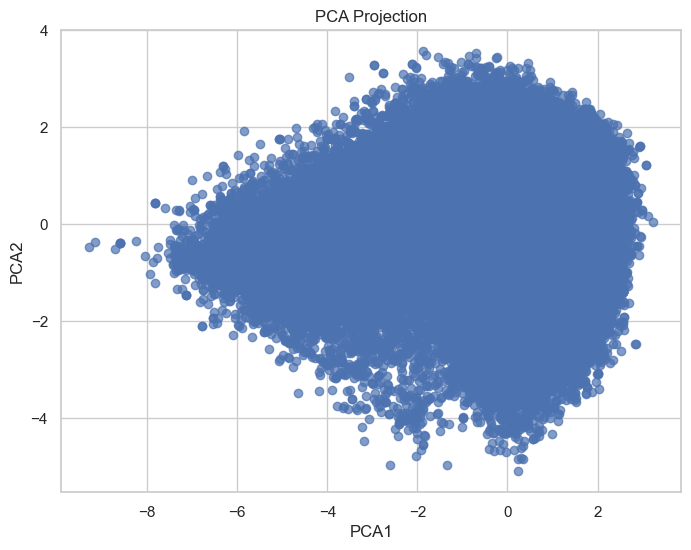

Plot saved as ./eda/silhouette_method_subsampled_pca.png


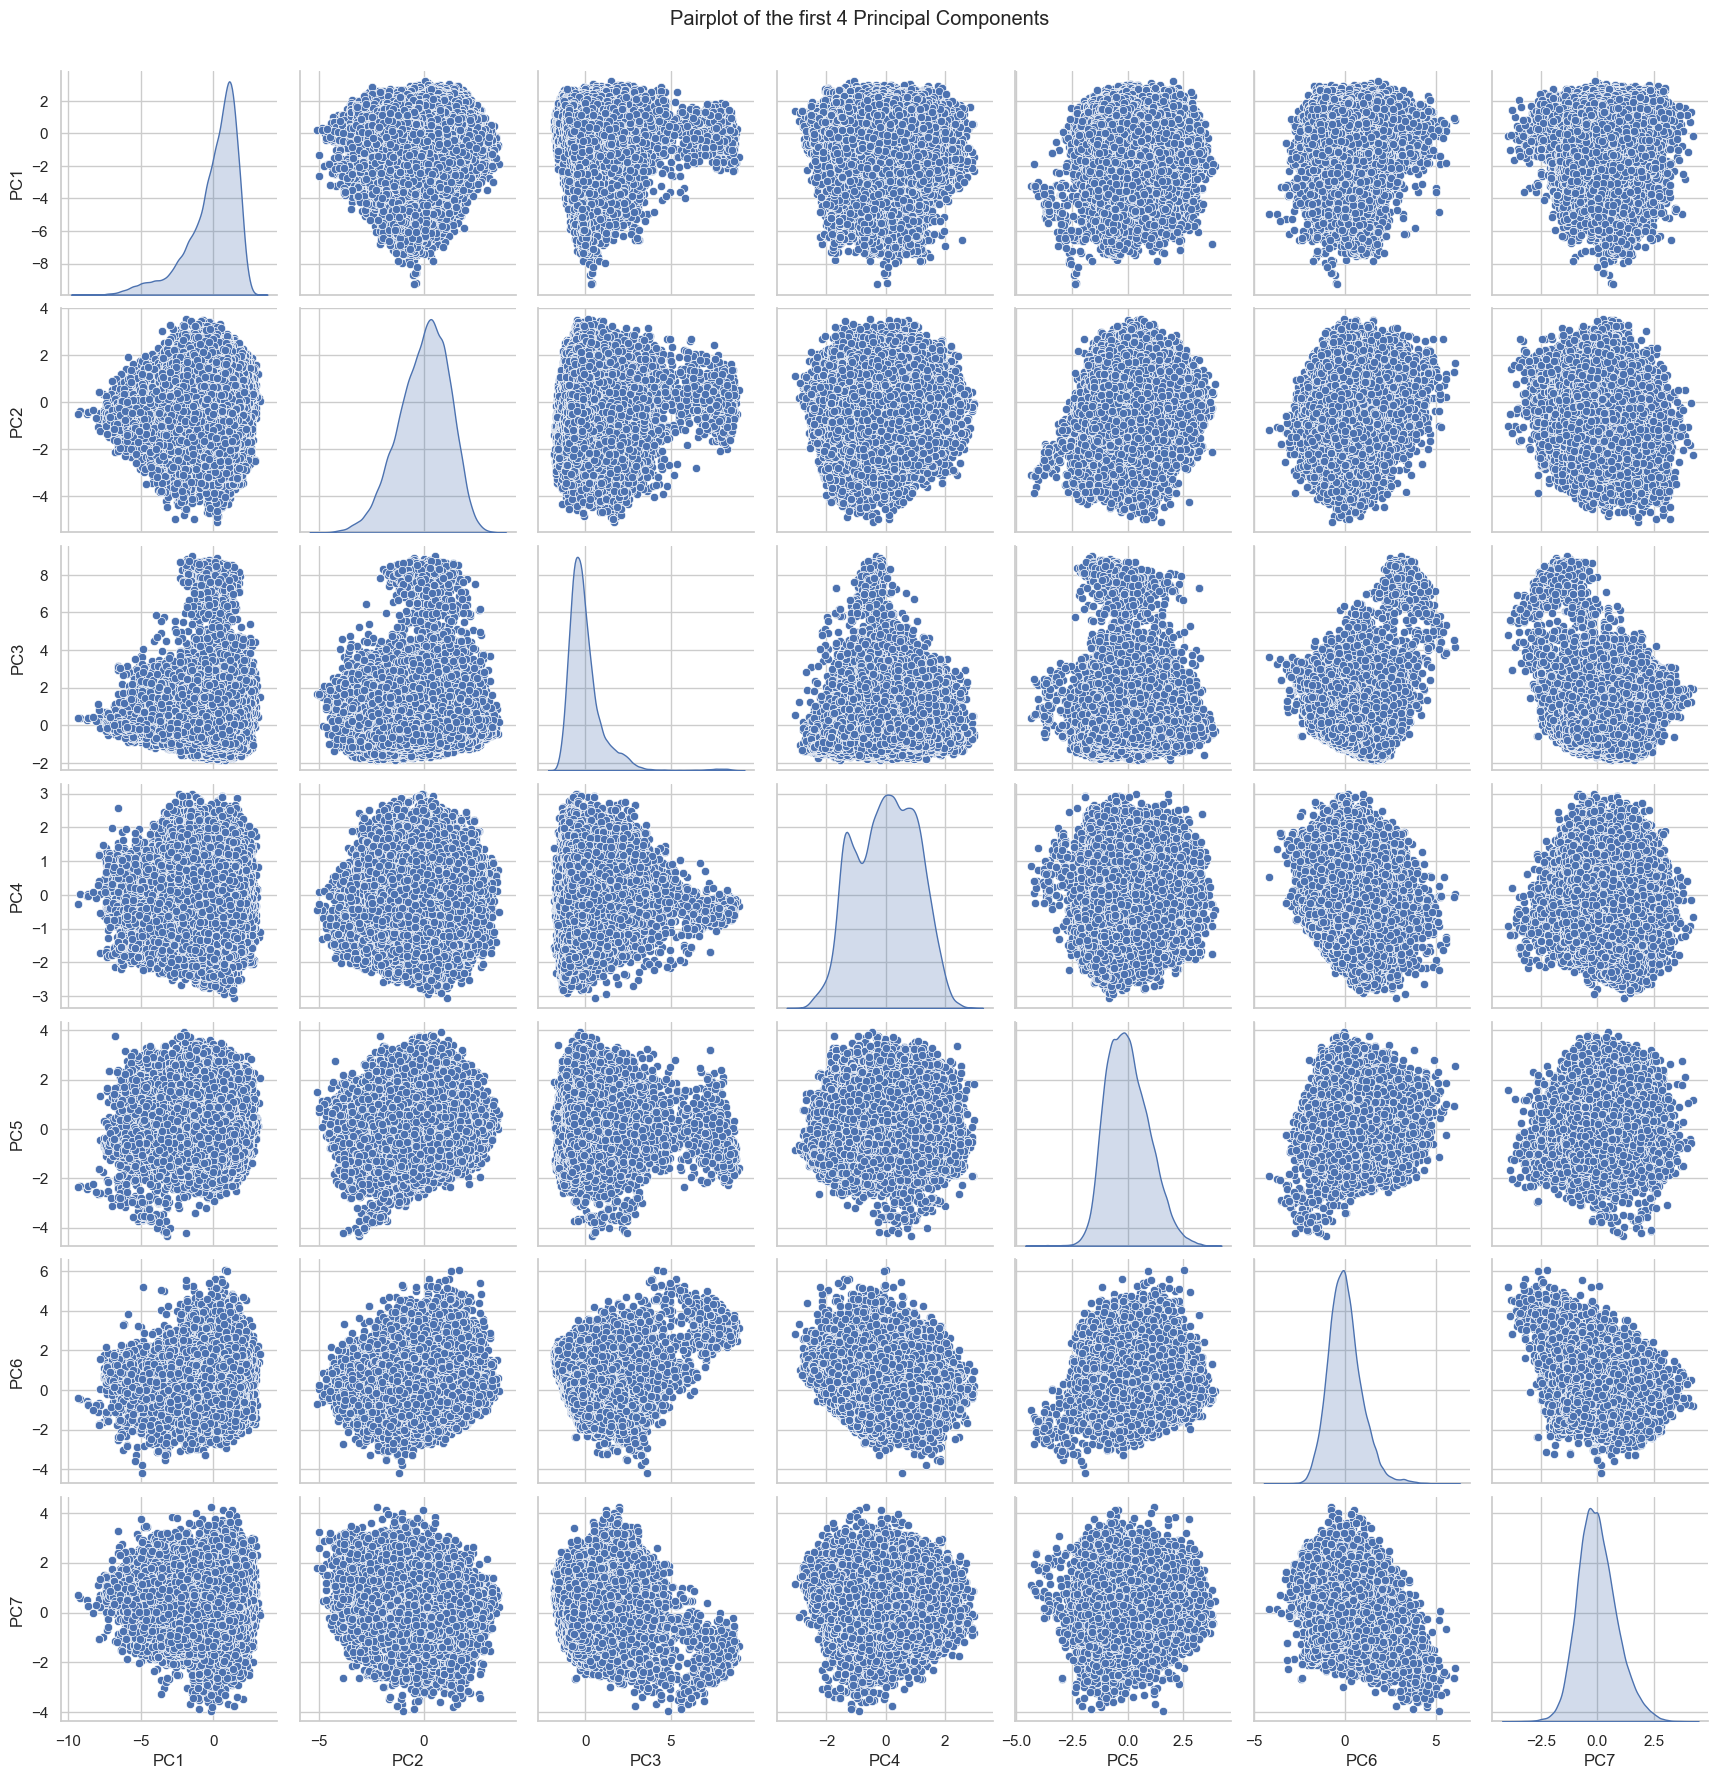

==== Starting: determine_kmeans_n_cluster
Testing k=2
Testing k=3
Testing k=4
Testing k=5
Testing k=6
Testing k=7
Testing k=8
Testing k=9
Testing k=10
Testing k=11
Testing k=12
Testing k=13
Testing k=14


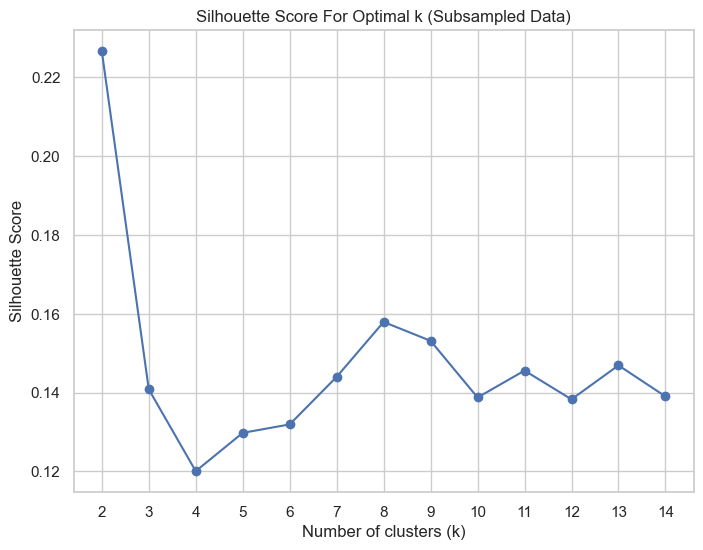

Computing inertia for k=2 ...
Computing inertia for k=3 ...
Computing inertia for k=4 ...
Computing inertia for k=5 ...
Computing inertia for k=6 ...
Computing inertia for k=7 ...
Computing inertia for k=8 ...
Computing inertia for k=9 ...
Computing inertia for k=10 ...
Computing inertia for k=11 ...
Computing inertia for k=12 ...
Computing inertia for k=13 ...
Computing inertia for k=14 ...


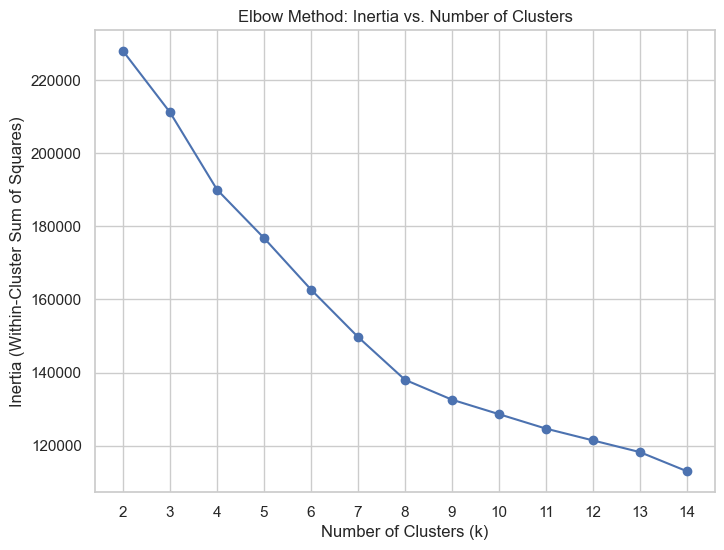

[227865.26743618524, 211102.46107160347, 189995.75782568453, 176772.26713477375, 162695.1298376475, 149740.30792666055, 138035.1673610249, 132593.86778109477, 128638.96021113251, 124684.50938835017, 121463.06596508436, 118266.22714631233, 113046.15533890764]
==== Starting: determine_k_using_indices
Computing indices for k=2 ...
Computing indices for k=3 ...
Computing indices for k=4 ...
Computing indices for k=5 ...
Computing indices for k=6 ...
Computing indices for k=7 ...
Computing indices for k=8 ...
Computing indices for k=9 ...
Computing indices for k=10 ...
Computing indices for k=11 ...
Computing indices for k=12 ...
Computing indices for k=13 ...
Computing indices for k=14 ...


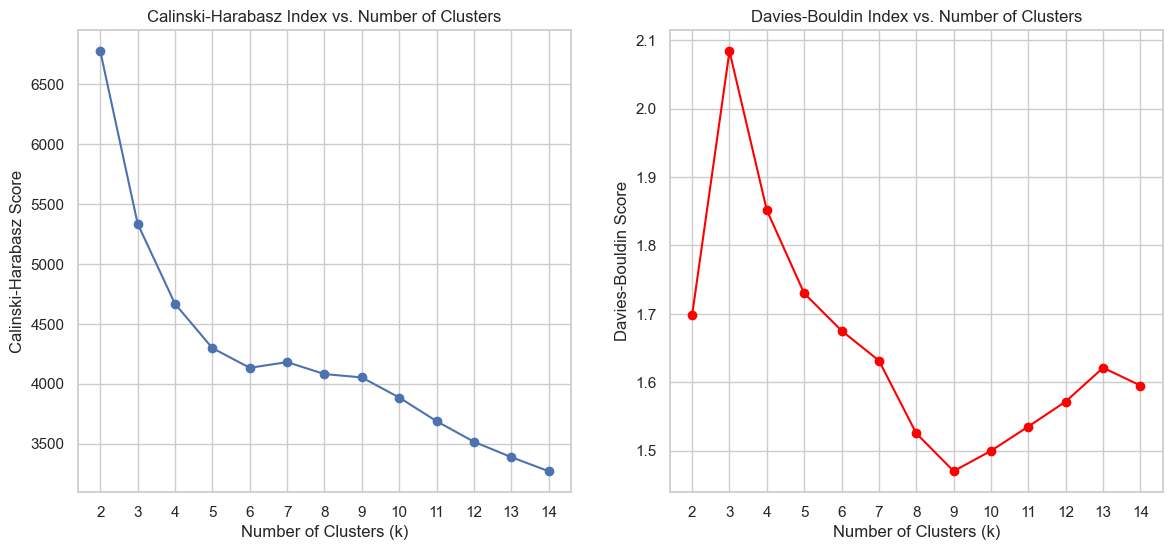

ch_scores [np.float64(6775.144960673572), np.float64(5335.260241292145), np.float64(4667.074748343789), np.float64(4298.012600171732), np.float64(4133.4626224753565), np.float64(4181.019916872144), np.float64(4081.211314883675), np.float64(4053.1663921480376), np.float64(3885.537922469797), np.float64(3688.2176068002527), np.float64(3516.426742838589), np.float64(3388.2345195723137), np.float64(3271.124027202647)]
db_scores [np.float64(1.6981855226517746), np.float64(2.0839209145630924), np.float64(1.8515077665663995), np.float64(1.7301055490340407), np.float64(1.675494060095805), np.float64(1.6318648603716321), np.float64(1.5255377975083395), np.float64(1.4702640262634392), np.float64(1.500004832954054), np.float64(1.5355234121112118), np.float64(1.5720166027988463), np.float64(1.6214008783823837), np.float64(1.5953326154221263)]
==== Starting: run_kmeans
K-Means clustering completed with 8 clusters.

K-Means Cluster Centroids (in scaled space):
   acousticness  danceability    energy

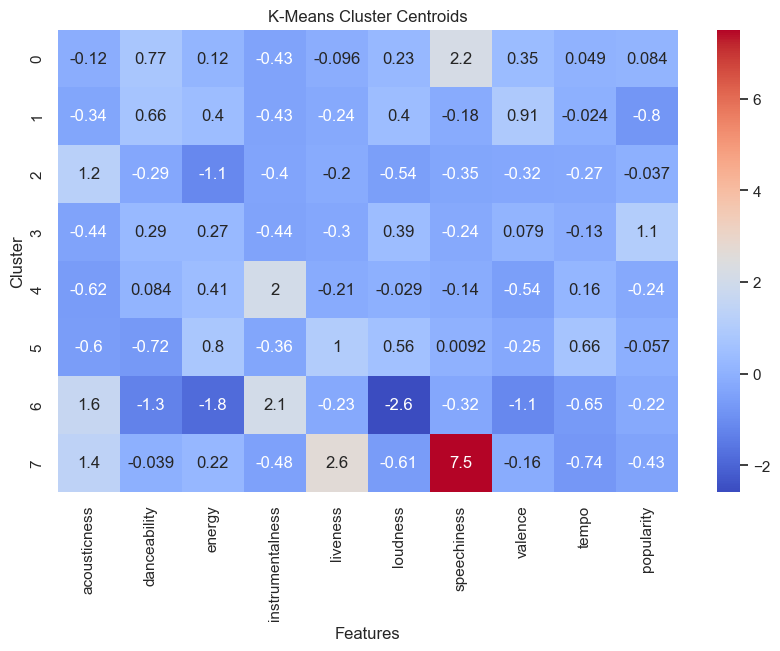

/Users/sid/Desktop/ML2/Final/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


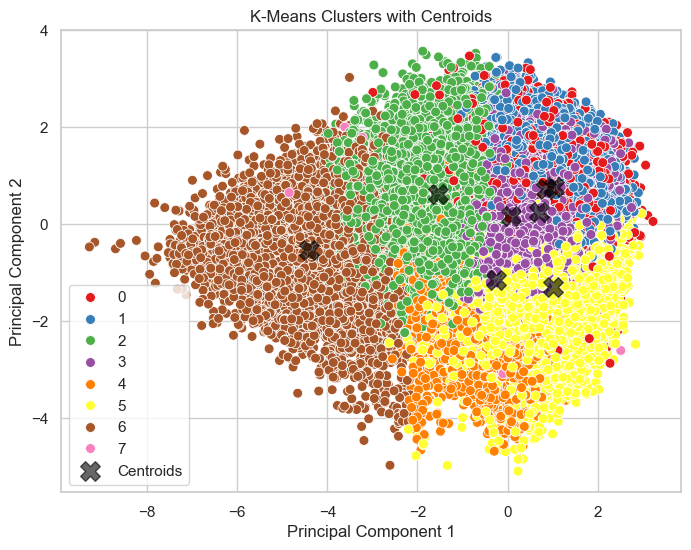

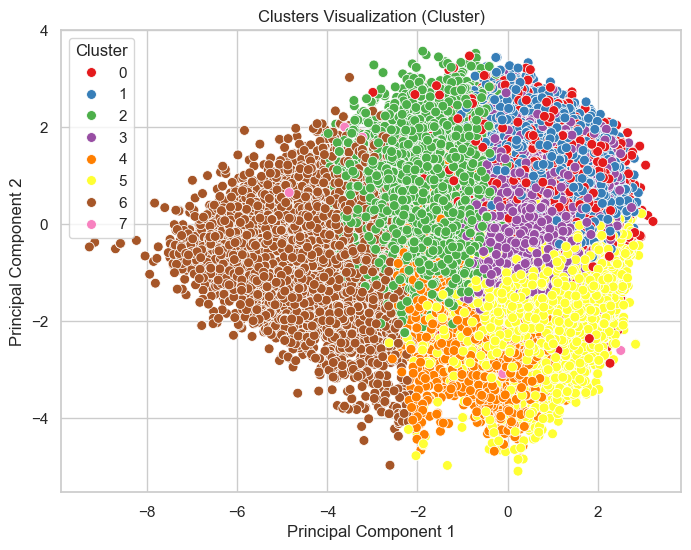

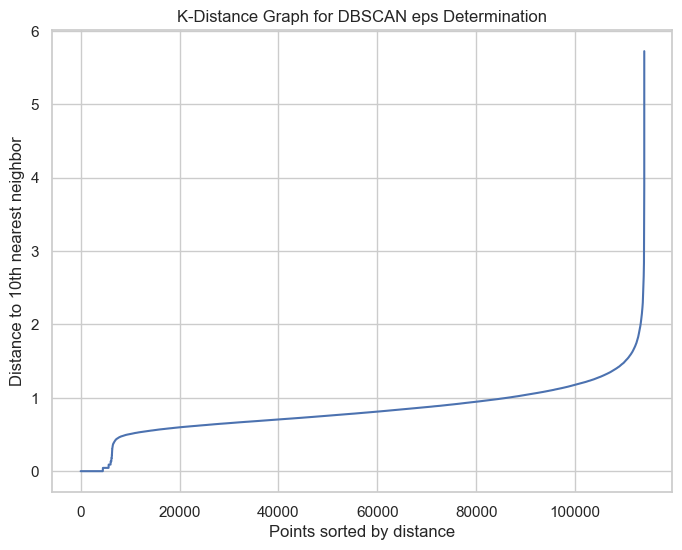

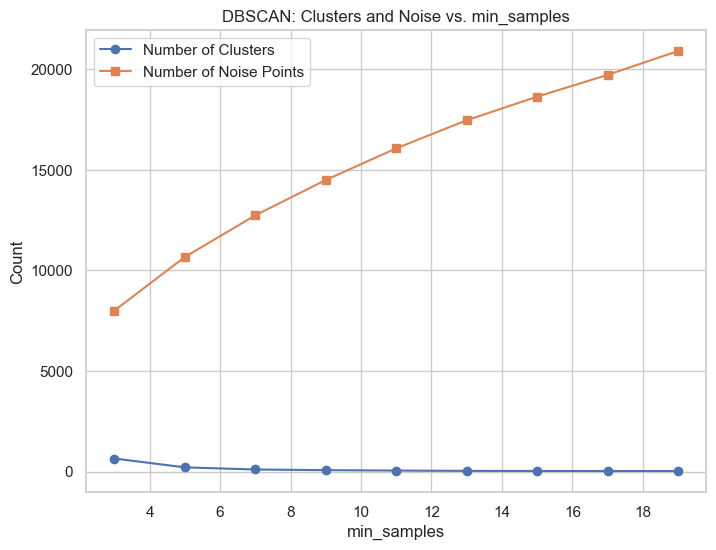

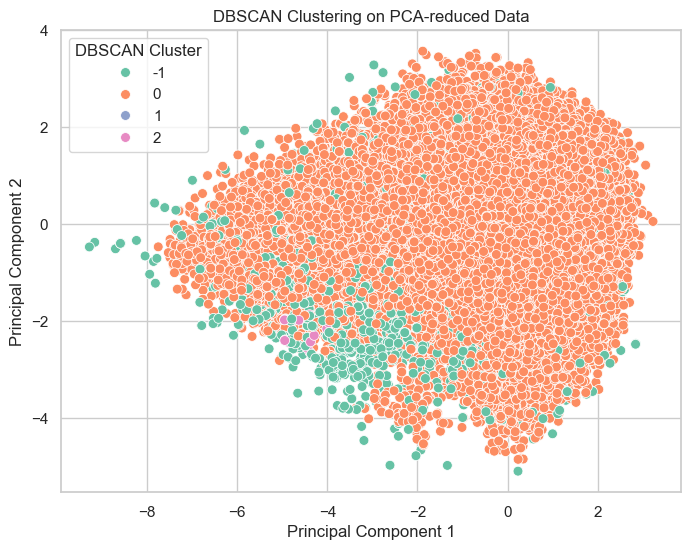

DBSCAN found 4 clusters (excluding noise).
Linkage: ward - Silhouette Score: 0.166
Linkage: complete - Silhouette Score: 0.310
Linkage: average - Silhouette Score: 0.465
Linkage: single - Silhouette Score: 0.465


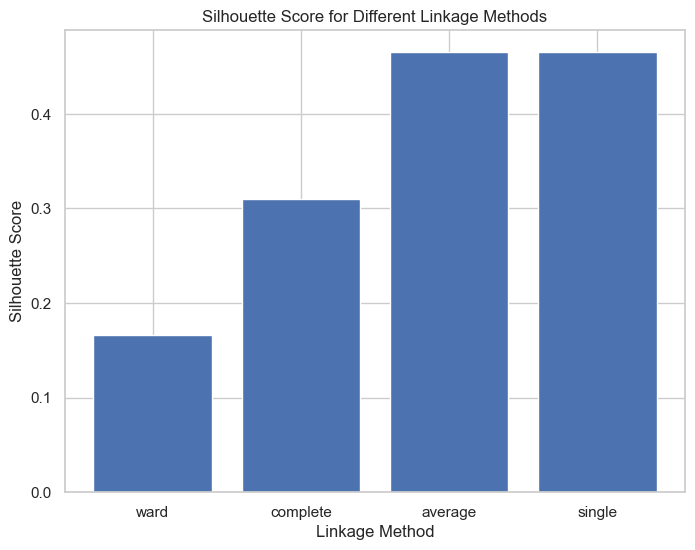

Linkage analysis saved as ./eda/agglo_hp_linkage.png.


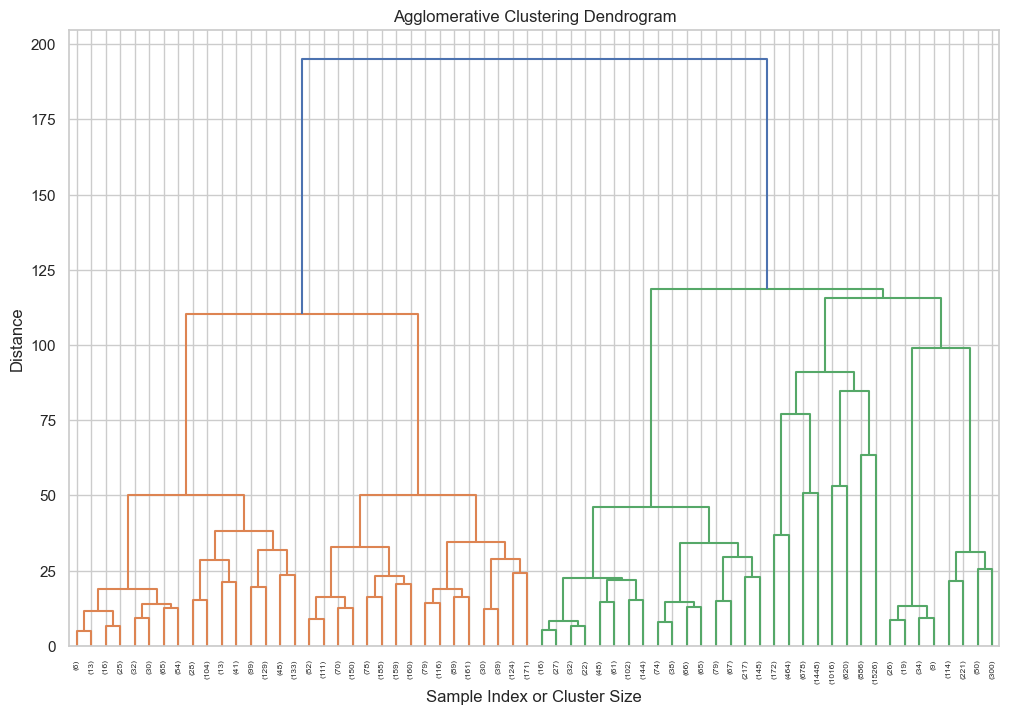

Dendrogram saved as ./eda/agglo_hp_dendrogram.png.


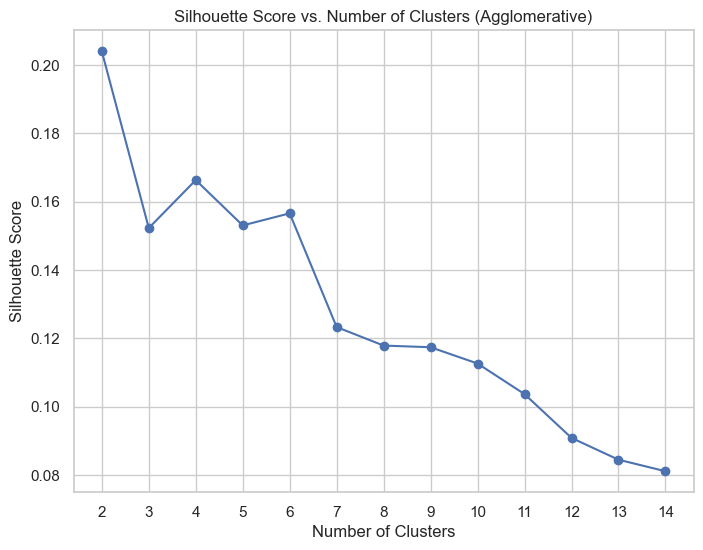

Silhouette score plot saved as ./eda/agglo_hp_silhouette.png.


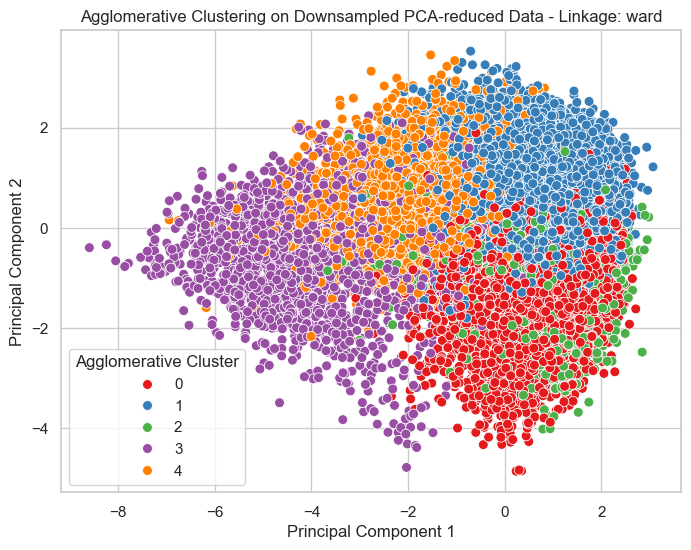

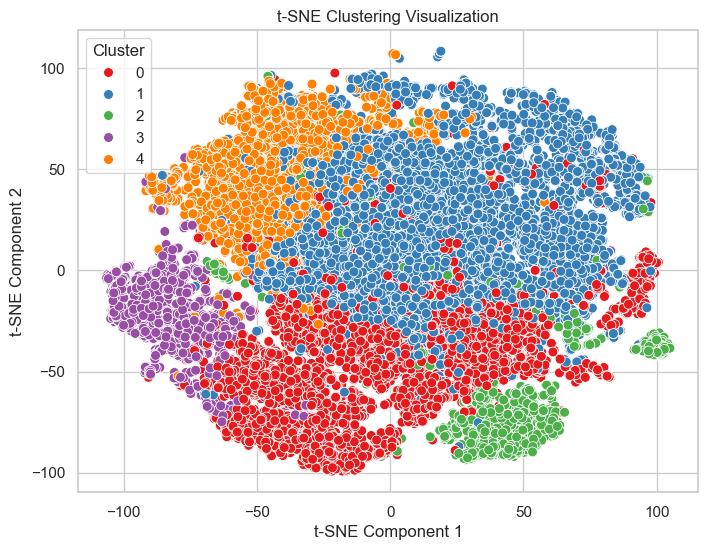

Cluster Summary (Means):
         acousticness  danceability    energy  instrumentalness  liveness  \
Cluster                                                                     
0            0.102290      0.517909  0.786441          0.281254  0.197565   
1            0.247384      0.642565  0.689375          0.030617  0.191644   
2            0.372666      0.541635  0.706350          0.028990  0.543011   
3            0.730350      0.417897  0.284130          0.727852  0.172498   
4            0.642849      0.526410  0.412625          0.047726  0.175867   

          loudness  speechiness   valence       tempo  popularity  
Cluster                                                            
0        -6.497891     0.080525  0.393660  134.294759   33.068190  
1        -6.850399     0.088626  0.575655  118.677135   34.044227  
2        -7.655766     0.178084  0.506776  121.911176   34.837852  
3       -17.715584     0.058972  0.250312  109.511754   28.866003  
4       -10.603943     0.05

/var/folders/jg/61jrbytj0kx23wtjyx9kf1r00000gn/T/ipykernel_1770/572036222.py:602: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_sample_orig, palette='Set1', ax=axes[i])
/var/folders/jg/61jrbytj0kx23wtjyx9kf1r00000gn/T/ipykernel_1770/572036222.py:602: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_sample_orig, palette='Set1', ax=axes[i])
/var/folders/jg/61jrbytj0kx23wtjyx9kf1r00000gn/T/ipykernel_1770/572036222.py:602: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=fe

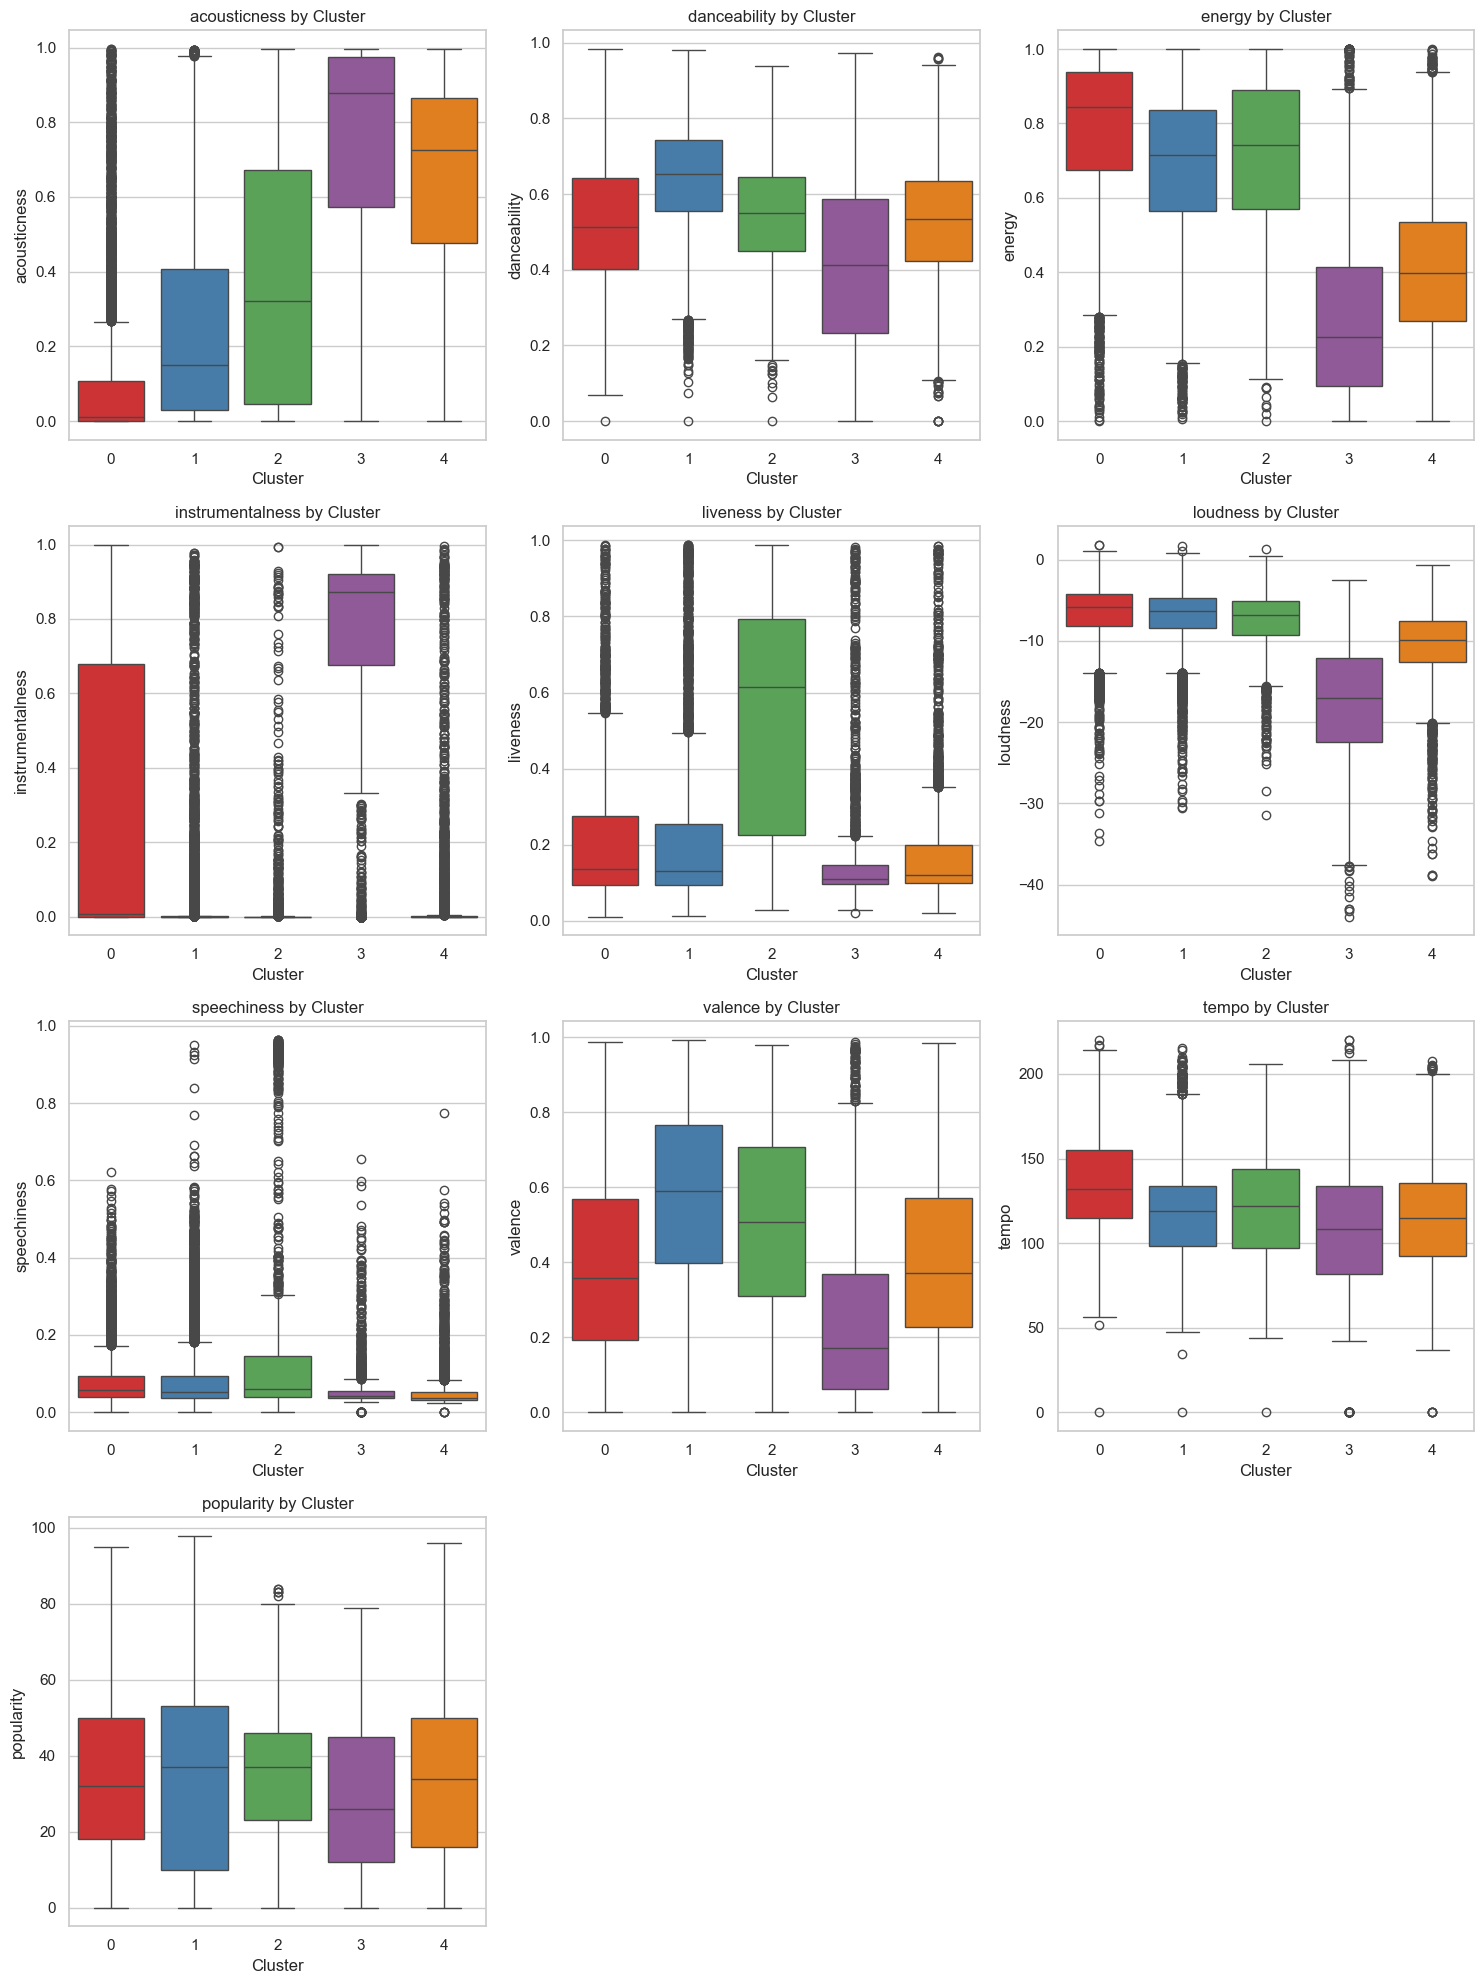

In [2]:
if __name__ == '__main__':
    main(False)